# CME 291 Project

In [3]:
# !pip install pandas
# !pip install dask
# !pip install numpy
# !pip install fuzzywuzzy
# !pip install matplotlib
# !pip install seaborn

import pandas as pd
import dask.dataframe as dd
import numpy as np
import math
from fuzzywuzzy import fuzz, process
import seaborn as sns  # Seaborn enhances Matplotlib for statistical data visualization
import matplotlib.pyplot as plt

C:\Users\cayal\AppData\Local\Temp\ipykernel_6336\2872786506.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\cayal\AppData\Local\Temp\ipykernel_6336\2872786506.py:9: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning

## Function Library

In [4]:
def geneonly():
    gbe_col_names = ["gene", "log10_BF_new_method"]
    alpha_col_names = ["gene", "combined"]
    df_gbe = pd.read_csv('updated_gbe_lof_burden_with_se_bf.tsv', sep="\t", usecols=gbe_col_names, dtype={"gene": str, "log10_BF_new_method": float}).dropna()
    df_alpha = pd.read_csv('alphamissense_modelcomparison_combined.tsv', sep='\t', usecols=alpha_col_names, dtype={"gene": str, "combined": float}).dropna()  # Adjust chunksize as needed

    result_df_gbe = df_gbe.groupby('gene').agg({'log10_BF_new_method': "sum"}).reset_index()
    result_df_alpha = df_alpha.groupby('gene').agg({'combined': "sum"}).reset_index()

    print(result_df_gbe.head())
    print(result_df_alpha.head())

    result_df = pd.merge(result_df_gbe, result_df_alpha, on='gene', how='outer').fillna(0)

    result_df['Merged_BF_Vals'] = result_df['combined'] + result_df['log10_BF_new_method']
    result_df.drop(['combined', 'log10_BF_new_method'], axis=1, inplace=True)

    print(result_df.head())

    result_df.to_csv('gene_seperated.tsv', sep="\t")

In [5]:
def genefuzzy():
    def gene_match_and_name_fuzzy(df):
        groups = df.groupby("gene")
        result_rows = []
        
        for name, data in groups:
            print(name)
            if len(data) < 1:
                result_rows.extend(data.to_dict(orient='records'))
            else:
                summed_data = data.groupby('phenostring').agg({'log10_BF_new_method': "sum"}).reset_index()
                ps = summed_data['phenostring'].tolist()
                partition_len = len(ps)//10
                unassigned = ps
                while(len(unassigned) > 0):
                    # print(len(unassigned))
                    lead_word = unassigned[0]
                    if (len(unassigned) <= partition_len or partition_len < 1):
                        print("Below level")
                        best_grouping = process.extract(lead_word, unassigned, scorer=fuzz.ratio, limit=None)
                        best_grouping_names = unassigned
                        unassigned = []
                    else:
                        best_grouping = process.extract(lead_word, unassigned, scorer=fuzz.ratio, limit=partition_len)
                        best_grouping_names = [a for (a,b) in best_grouping]
                        unassigned = [w for w in unassigned if w not in best_grouping_names]


                    for i, row in summed_data.iterrows():
                        if row['phenostring'] == lead_word:
                            row_dict = row.to_dict()
                            row_dict['BestGrouping'] = best_grouping
                            for j, r2 in summed_data.iterrows():
                                if r2['phenostring'] in best_grouping_names:
                                    row_dict['log10_BF_new_method'] += r2['log10_BF_new_method']
                            result_rows.append(row_dict)   
                    summed_data = summed_data[~summed_data['phenostring'].isin(best_grouping_names)]
        result_df = pd.DataFrame(result_rows)
        return result_df
    
    gbe_col_names = ["gene", "phenostring", "log10_BF_new_method"]
    alpha_col_names = ["gene", "phenoname", "combined"]
    df_gbe = pd.read_csv('updated_gbe_lof_burden_with_se_bf.tsv', sep="\t", usecols=gbe_col_names, dtype={"gene": str, "phenostring": str, "log10_BF_new_method": float}).dropna()
    df_alpha = pd.read_csv('alphamissense_modelcomparison_combined.tsv', sep='\t', usecols=alpha_col_names, dtype={"gene": str, "phenoname": str, "combined": float}).dropna()  # Adjust chunksize as needed
    df_alpha.rename(columns={"phenoname":"phenostring", "combined":"log10_BF_new_method"}, inplace=True)

    df_comb = pd.concat([df_gbe, df_alpha], ignore_index=True)

    df_comb_full = gene_match_and_name_fuzzy(df_comb)
    df_comb_full.to_csv('gene_fuzz_seperated.tsv', sep="\t")

In [6]:
def genefuzzy_mod():
    def gene_match_and_name_fuzzy(df_a, df_b):
        groups = df_a.groupby("gene")
        result_rows = []
        
        for name, data in groups:
            print(name)
            df_b_gene = df_b[df_b['gene'] == name]
            df_b = df_b.drop(df_b_gene.index)
            df_a_gene = data.groupby('phenostring').agg({'log10_BF_new_method': "sum"}).reset_index()
            df_b_gene = df_b_gene.groupby('phenostring').agg({'log10_BF_new_method': "sum"}).reset_index()
            ps = df_a_gene['phenostring'].tolist()
            unassigned = df_b_gene['phenostring'].tolist()
            df_a_score = df_a_gene['log10_BF_new_method'].tolist()
            for i in range(len(ps)):
                lead_word = ps[i]
                if (unassigned != []):
                    if (i == len(ps) -1):
                        best_grouping = process.extract(lead_word, unassigned, scorer=fuzz.ratio, limit=None)
                        best_grouping_names = [a for (a,b) in best_grouping]
                        unassinged = []
                    else:
                        best_grouping = process.extract(lead_word, unassigned, scorer=fuzz.ratio, limit=None)
                        best_grouping_names = [a for (a,b) in best_grouping if b > 50]
                        unassigned = [w for w in unassigned if w not in best_grouping_names]

                    df_grouping = df_b_gene[df_b_gene['phenostring'].isin(best_grouping_names)]
                    total_sum = df_grouping['log10_BF_new_method'].sum()
                    comb_sum = total_sum + df_a_score[i]
                    group_dict = {'gene': name, 
                                  'finngen_phenostring': lead_word,
                                  'ukbiobank_phenostrings': str(best_grouping_names), 
                                  'finngen_l10_BF': df_a_score[i], 
                                  'ukbiobank_l10_BF': total_sum,
                                  'combined_l10_BF': comb_sum}
                else:
                    group_dict = {'gene': name, 
                                  'finngen_phenostring': lead_word,
                                  'ukbiobank_phenostrings': "[]", 
                                  'finngen_l10_BF': df_a_score[i], 
                                  'ukbiobank_l10_BF': 0,
                                  'combined_l10_BF': df_a_score[i]}
                result_rows.append(group_dict)
        result_df = pd.DataFrame(result_rows)
        return result_df
    
    gbe_col_names = ["gene", "phenostring", "log10_BF_new_method"]
    alpha_col_names = ["gene", "phenoname", "combined"]
    df_gbe = pd.read_csv('updated_gbe_lof_burden_with_se_bf.tsv', sep="\t", usecols=gbe_col_names, dtype={"gene": str, "phenostring": str, "log10_BF_new_method": float}).dropna()
    df_alpha = pd.read_csv('alphamissense_modelcomparison_combined.tsv', sep='\t', usecols=alpha_col_names, dtype={"gene": str, "phenoname": str, "combined": float}).dropna()  # Adjust chunksize as needed
    df_alpha.rename(columns={"phenoname":"phenostring", "combined":"log10_BF_new_method"}, inplace=True)

    # df_comb = pd.concat([df_gbe, df_alpha], ignore_index=True)

    df_comb_full = gene_match_and_name_fuzzy(df_gbe, df_alpha)
    df_comb_full.to_csv('gene_fuzz_finngen_seperated.tsv', sep="\t")

In [7]:
def convert_to_gainDF():
    col_names = ["gene", "finngenn_l10_BF", "ukbiobank_l10_BF", "combined_l10_BF", "finngenn_phenostring", "ukbiobank_phenostrings"]
    df = pd.read_csv('gene_fuzz_finngen_seperated.tsv', sep="\t", usecols=col_names, dtype={"gene": str, "finngenn_l10_BF": float, "ukbiobank_l10_BF": float, "combined_l10_BF": float, "finngenn_phenostring": str, "ukbiobank_phenostrings":str}).dropna()

    df_gain_above2 = df[df['combined_l10_BF'] >= 2.0]

    df_gain_above2['combined_l10_BF_gain'] = ((df_gain_above2['combined_l10_BF'] - df_gain_above2['ukbiobank_l10_BF']) / df_gain_above2['ukbiobank_l10_BF']) * 100  # Replace this with your desired mathematical operation

    # Drop the original column if you want to replace it
    # df_gain_above2.drop('combined_l10_BF', axis=1, inplace=True)
    df_gain_above2.replace([np.inf, -np.inf], 0, inplace=True)

    df_gain_above2.sort_values(by='combined_l10_BF_gain', ascending=False, inplace=True)

    # Reset the indices
    df_gain_above2.reset_index(drop=True, inplace=True)
    print(df_gain_above2.head(20))

    df_gain_above2.to_csv('gene_fuzz_finngen_gain.tsv', sep="\t")

In [8]:
def visualize_log10BF():
    col_names = ["gene", "finngen_l10_BF", "ukbiobank_l10_BF", "combined_l10_BF"]
    df = pd.read_csv('gene_fuzz_finngen_seperated.tsv', sep="\t", usecols=col_names, dtype={"gene": str, "finngen_l10_BF": float, "ukbiobank_l10_BF": float, "combined_l10_BF": float}).dropna()

    df_aboveneg10 = df[df['ukbiobank_l10_BF'] >= -10.0]
    df_bt10 = df_aboveneg10[df_aboveneg10['ukbiobank_l10_BF'] <= 10.0]
    # Set a seaborn style for better aesthetics (optional)
    sns.set(style="whitegrid")

    # Create a dot plot with different colors for each 'classifier'
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='ukbiobank_l10_BF', y='combined_l10_BF', hue='gene', data=df, s=100, palette='Set1')

    # Add labels and title
    plt.ylabel('Combined log10 BF')
    plt.xlabel('UK Biobank log10 BF')
    plt.title('log10 Bayes Factor')

    # custom_ticks = np.arange(int(df['finngenn_l10_BF']).min(), int(df['finngenn_l10_BF']).max() + 1, 100)
    # plt.xticks(custom_ticks)
    plt.legend().set_visible(False)

    plt.xscale('symlog')
    plt.yscale('symlog')
    print(df['ukbiobank_l10_BF'].corr(df['combined_l10_BF']))

    # Show the plot
    plt.savefig('log10BF_plot.png')

    # Create a dot plot with different colors for each 'classifier'
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='ukbiobank_l10_BF', y='combined_l10_BF', hue='gene', data=df_bt10, s=100, palette='Set1')

    # Add labels and title
    plt.ylabel('Combined log10 BF')
    plt.xlabel('UK Biobank log10 BF')
    plt.title('log10 Bayes Factor on Reduced Range')

    # custom_ticks = np.arange(int(df['finngenn_l10_BF']).min(), int(df['finngenn_l10_BF']).max() + 1, 100)
    # plt.xticks(custom_ticks)
    plt.legend().set_visible(False)

    plt.xscale('symlog')
    plt.yscale('symlog')
    print(df_bt10['ukbiobank_l10_BF'].corr(df_bt10['combined_l10_BF']))

    # Show the plot
    plt.savefig('log10BF_plot_rr.png')

In [19]:
def visualize_log10BF_gain():
    col_names = ["gene", "finngen_l10_BF", "ukbiobank_l10_BF", "combined_l10_BF_gain", "finngen_phenostring"]
    df = pd.read_csv('gene_fuzz_finngen_gain.tsv', sep="\t", usecols=col_names, dtype={"gene": str, "finngen_l10_BF": float, "ukbiobank_l10_BF": float, "combined_l10_BF_gain": float, "finngen_phenostring": str}).dropna()
    
    # Set a seaborn style for better aesthetics (optional)
    sns.set(style="whitegrid")

    # Create a dot plot with different colors for each 'classifier'
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='ukbiobank_l10_BF', y='combined_l10_BF_gain', hue='gene', data=df, s=100, palette='Set1')

    # Add labels and title
    plt.ylabel('Combined log10 BF Gain %')
    plt.xlabel('UK Biobank log10 BF')
    plt.title('log10 Bayes Factor Gain %')

    # custom_ticks = np.arange(int(df['finngenn_l10_BF']).min(), int(df['finngenn_l10_BF']).max() + 1, 100)
    # plt.xticks(custom_ticks)
    plt.legend().set_visible(False)

    plt.xscale('log')
    plt.yscale('log')
    print((np.log(df['ukbiobank_l10_BF']).replace([np.inf, -np.inf], 0)).corr(np.log(df['combined_l10_BF_gain']).replace([np.inf, -np.inf], 0)))

    # Show the plot
    plt.savefig('log10BF_gain_plot.png')

    df_agg = df.groupby(['gene']).agg({'finngen_l10_BF': 'mean', 'ukbiobank_l10_BF': 'mean', 'combined_l10_BF_gain': 'mean'}).reset_index()
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='ukbiobank_l10_BF', y='combined_l10_BF_gain', hue='gene', data=df_agg, s=100, palette='Set1')

    # Add labels and title
    plt.ylabel('Combined log10 BF Average Gain %')
    plt.xlabel('UK Biobank log10 Average BF')
    plt.title('log10 Bayes Factor Average Gain % By Gene')

    # custom_ticks = np.arange(int(df['finngenn_l10_BF']).min(), int(df['finngenn_l10_BF']).max() + 1, 100)
    # plt.xticks(custom_ticks)
    plt.legend().set_visible(False)

    plt.xscale('log')
    plt.yscale('log')
    print((np.log(df_agg['ukbiobank_l10_BF']).replace([np.inf, -np.inf], 0)).corr(np.log(df_agg['combined_l10_BF_gain']).replace([np.inf, -np.inf], 0)))
    plt.savefig('log10BF_avg_gain_plot.png')
    df_agg.sort_values(by='combined_l10_BF_gain', ascending=False, inplace=True)
    print(df_agg.head())
    df.sort_values(by='combined_l10_BF_gain', ascending=False, inplace=True)
    print(df.head())

## Function Calls and Descriptions

0.9997449350221667
0.46181525322572514


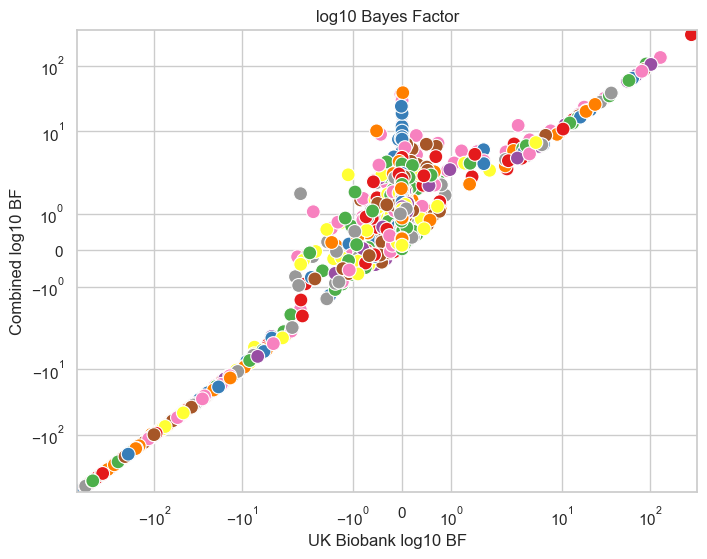

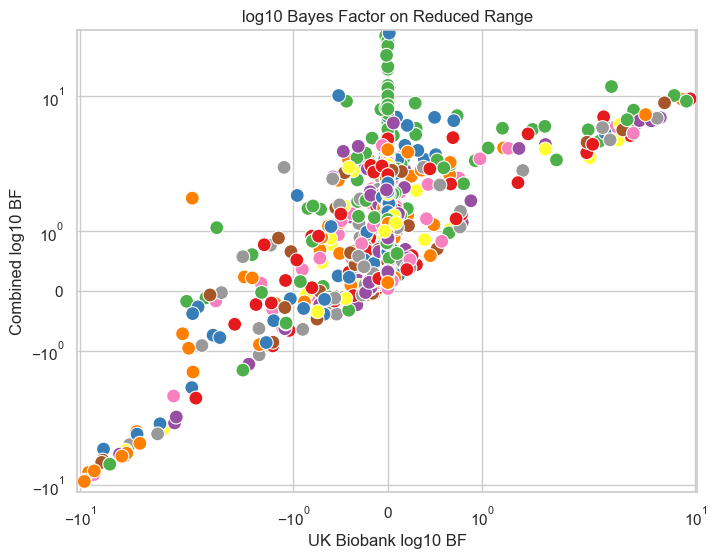

In [10]:
visualize_log10BF()

As we can note above, there are intersting behaviors when we measure the relationship between the log 10 Bayes factor obtained from the UK Biobank dataset and the combined dataset when the FinnGen dataset is added. What we would expect, given that AlphaMissense is supposed to be adding new signals, is that there is a non-linear relationship between the two. What we do notice instead is that there is a significant linear correlation between the two. Off of my current assumptions, I would assume that there are no new signals being provided, given a correlation of 99.97%. However, we can observe that this is not the case throughout the entirety of the dataset. Specifically, as we get closer to a log10 BF of 0 for the UK Biobank dataset, there is an increasing deviation from linearity. This seems to indicate that the addition of the FinnGen dataset provides more information where the AlphaMissense lacks. The first graph shows the full dataset combined, while the second limits the range of the UK Biobank log10 BF to a maximum magnitude of 10.

c:\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


-0.6123435935790242


c:\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


-0.6041466187511871
       gene  finngen_l10_BF  ukbiobank_l10_BF  combined_l10_BF_gain
73    RELCH        2.231597         -0.003254         389337.459027
32      FLG        8.044871          2.298348          32315.601901
78     SCLY        2.115308          0.019757          10706.669690
61    PCGF3        2.174663          0.983056           6430.858488
98  TXNDC15        1.994244          0.051625           3862.951375
    gene                         finngen_phenostring  finngen_l10_BF  \
0  RELCH             Paracetamol of NSAID medication        2.220024   
1    FLG                           Atopic dermatitis       38.891586   
2  RELCH                        Other heart diseases        2.438114   
3  CHEK2  Myeloproliferative diseases (CML excluded)       12.092031   
4  PCGF3                               Arthropathies        2.227256   

   ukbiobank_l10_BF  combined_l10_BF_gain  
0          0.000207          1.072311e+06  
1          0.014925          2.605792e+05  
2      

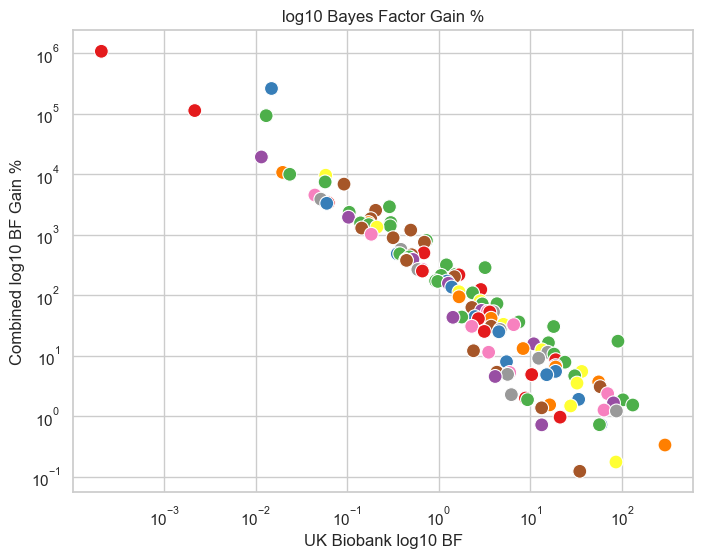

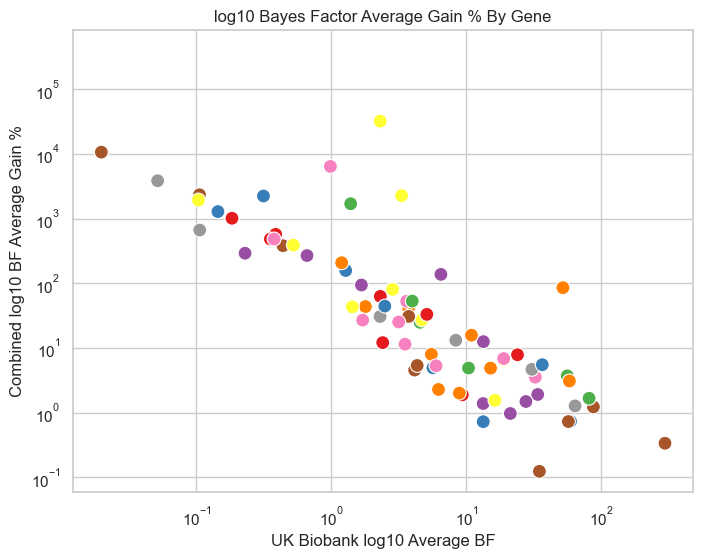

In [20]:
visualize_log10BF_gain()

As we can see in the graphs above, there seems to be a downwards trend between information provided from the log10 Bayes factor we get from the UK Biobank dataset run through AlphaMissense. Specifically, the greater the value of the log10 Bayes Factor we get from the UK Biobank dataset, the smaller the percentage of gain we get from combining this dataset with the Finngen dataset. The first graph indicates this quantity in terms of each individual entry in the combined dataset, while the second graph isolates and combines the entries by gene code. These graphs are on a logarithmic scale, so this trend between the UK Biobank log10 BF and the Combined log10 BF gain % must be a negative logarithmic relationship.

## Alternate Modifications

In [12]:
gain_col_names = ["gene", "finngen_l10_BF", "ukbiobank_l10_BF", "combined_l10_BF_gain", "finngen_phenostring"]
df_gain = pd.read_csv('gene_fuzz_finngen_gain.tsv', sep="\t", usecols=gain_col_names, dtype={"gene": str, "finngen_l10_BF": float, "ukbiobank_l10_BF": float, "combined_l10_BF_gain": float, "finngen_phenostring": str}).dropna()

col_names = ["gene", "finngen_l10_BF", "ukbiobank_l10_BF", "combined_l10_BF", "finngen_phenostring"]
df_L10BF = pd.read_csv('gene_fuzz_finngen_seperated.tsv', sep="\t", usecols=col_names, dtype={"gene": str, "finngen_l10_BF": float, "ukbiobank_l10_BF": float, "combined_l10_BF": float, "finngen_phenostring": str}).dropna()

print("Head of Gain Dataframe")
print(df_gain.head())
print("________________________________________________________________________________________________")
print()
print("Head of Original Combined Dataframe")
print(df_L10BF.head())
df_L10BF.head()

Head of Gain Dataframe
    gene                         finngen_phenostring  finngen_l10_BF  \
0  RELCH             Paracetamol of NSAID medication        2.220024   
1    FLG                           Atopic dermatitis       38.891586   
2  RELCH                        Other heart diseases        2.438114   
3  CHEK2  Myeloproliferative diseases (CML excluded)       12.092031   
4  PCGF3                               Arthropathies        2.227256   

   ukbiobank_l10_BF  combined_l10_BF_gain  
0          0.000207          1.072311e+06  
1          0.014925          2.605792e+05  
2          0.002168          1.124836e+05  
3          0.013057          9.261286e+04  
4          0.011578          1.923653e+04  
________________________________________________________________________________________________

Head of Original Combined Dataframe
     gene                                finngen_phenostring  finngen_l10_BF  \
0   A2ML1                Fracture of lumbar spine and pelvis      

,gene,finngen_phenostring,finngen_l10_BF,ukbiobank_l10_BF,combined_l10_BF
0,A2ML1,Fracture of lumbar spine and pelvis,0.891969,-0.119969,0.772000
1,A2ML1,"Melanocytic naevi, other sites/unspecified",0.274470,-0.201748,0.072722
2,A2ML1,Spondylosis,1.446986,-143.747395,-142.300409
3,ABCA13,"Beningn neoplasm: Meninges, unspecified",0.778755,-0.527350,0.251405
4,ABCA13,Premature separation of placenta [abruptio pla...,0.326721,-278.796782,-278.470061


From here, there are a few steps we can take. The main one which I want to consider, which I think could reveal more bias within the AlphaMissense testing, is whether or not genes within a specific family of genes are replicating the behavior that we are seeing above. If certain families with significant quantities of entries in the combined dataset exhibit different behavior, this could indicate where AlphaMissense fails to properly capture relationships. Especially since the log10 Bayes factor indicates our level of confidence in a missense variant being pathogenic, we want this behavior to be replicated across each class and family of gene. 

In [23]:
df_fp = df_L10BF.loc[(df_L10BF['ukbiobank_l10_BF'] > 0) & (df_L10BF['combined_l10_BF'] < 0)]
df_fp.head()

,gene,finngen_phenostring,finngen_l10_BF,ukbiobank_l10_BF,combined_l10_BF


In [28]:
df_fn = df_L10BF.loc[(df_L10BF['ukbiobank_l10_BF'] < 0) & (df_L10BF['combined_l10_BF'] > 0)]
df_fn.head()

,gene,finngen_phenostring,finngen_l10_BF,ukbiobank_l10_BF,combined_l10_BF
0,A2ML1,Fracture of lumbar spine and pelvis,0.891969,-0.119969,0.772000
1,A2ML1,"Melanocytic naevi, other sites/unspecified",0.274470,-0.201748,0.072722
3,ABCA13,"Beningn neoplasm: Meninges, unspecified",0.778755,-0.527350,0.251405
10,ABCC6,Acute nasopharyngitis(common cold),1.239296,-0.036777,1.202519
14,ABCC8,Other congenital malformations of digestive sy...,0.238882,-0.027451,0.211432


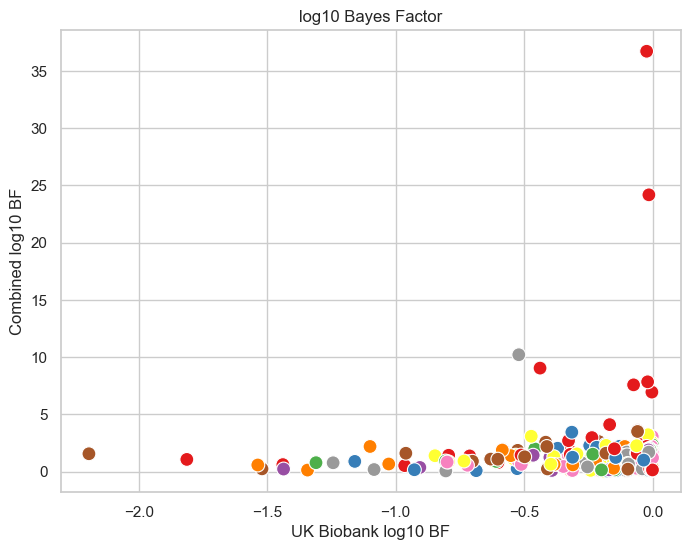

In [31]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='ukbiobank_l10_BF', y='combined_l10_BF', hue='gene', data=df_fn, s=100, palette='Set1')

# Add labels and title
plt.ylabel('Combined log10 BF')
plt.xlabel('UK Biobank log10 BF')
plt.title('log10 Bayes Factor')

# custom_ticks = np.arange(int(df['finngenn_l10_BF']).min(), int(df['finngenn_l10_BF']).max() + 1, 100)
# plt.xticks(custom_ticks)
plt.legend().set_visible(False)


In [41]:
genes_changed = df_fn['gene'].value_counts().reset_index()

genes_changed.columns = ['Value', 'Count']

genes_changed = genes_changed.groupby('Count')['Value'].apply(list).reset_index()

genes_changed.columns = ['Count', 'Values']

genes_changed['Num_Values'] = genes_changed['Values'].apply(len)
print(genes_changed)

   Count                                             Values  Num_Values
0      1  [PTPN22, PLA2G4D, PTCHD3, PSMC6, PSG4, PRKCZ, ...         122
1      2  [SSUH2, RNF215, DCDC1, DCDC2B, MALRD1, L1TD1, ...          49
2      3  [DNAH12, FRMD1, C2CD3, ACE, SPACA7, ORAI1, SMP...          16
3      4  [CD44, HGFAC, C1orf185, ARMC2, HMCN1, IQCE, RELA]           7
4      5                                     [CDK9, NBEAL1]           2
5      7                                            [LZTR1]           1
6     10                                            [CHEK2]           1
7     13                                            [NPHS1]           1
8     14                                            [ATG4C]           1


In [32]:
df_cfz = df_L10BF.loc[(df_L10BF['ukbiobank_l10_BF'] == 0) & (df_L10BF['combined_l10_BF'] != 0)]
df_cfz.head()

,gene,finngen_phenostring,finngen_l10_BF,ukbiobank_l10_BF,combined_l10_BF
6,ABCC12,"Adenocarcinoma, papilloma adenocarcinoma and m...",1.356828,0.0,1.356828
16,ABRAXAS1,Blepharochalasis,2.007992,0.0,2.007992
17,ABRAXAS1,Hallux rigidus,1.658550,0.0,1.658550
22,AC004233.2,Hyperuricaemia without signs of inflammatory a...,0.245945,0.0,0.245945
23,AC004233.2,Otitis externa,1.467477,0.0,1.467477


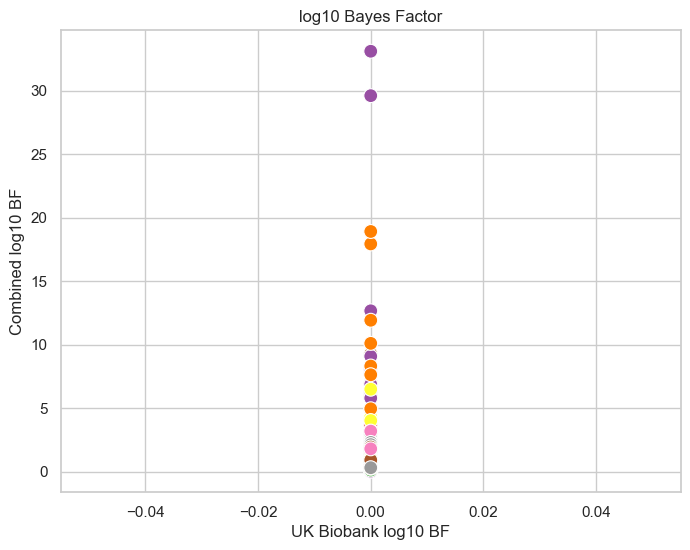

In [33]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='ukbiobank_l10_BF', y='combined_l10_BF', hue='gene', data=df_cfz, s=100, palette='Set1')

# Add labels and title
plt.ylabel('Combined log10 BF')
plt.xlabel('UK Biobank log10 BF')
plt.title('log10 Bayes Factor')

# custom_ticks = np.arange(int(df['finngenn_l10_BF']).min(), int(df['finngenn_l10_BF']).max() + 1, 100)
# plt.xticks(custom_ticks)
plt.legend().set_visible(False)